In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [2]:
# Read the csv file into a pandas DataFrame
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('Data_Combined.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse)
data.head()

,Yield on U.S. 10 Year Government Bond - %,S&P 500,NASDAQ 100,Bloomberg Dollar Index,Gold Price (Oz.) - USD,M2 Money Supply - USD Trillions
Date,,,,,,
2015-01-02,2.1105,2058.20,4230.24,1141.02,1188.39,NaN
2015-01-05,2.0320,2020.58,4160.96,1143.40,1204.86,NaN
2015-01-06,1.9402,2002.61,4110.83,1143.01,1218.58,NaN
2015-01-07,1.9677,2025.90,4160.00,1145.62,1211.41,NaN
2015-01-08,2.0179,2062.14,4240.55,1147.54,1208.79,NaN


In [3]:
N100_data = data[["NASDAQ 100"]].dropna()
N100_data.head()

,NASDAQ 100
Date,
2015-01-02,4230.24
2015-01-05,4160.96
2015-01-06,4110.83
2015-01-07,4160.00
2015-01-08,4240.55


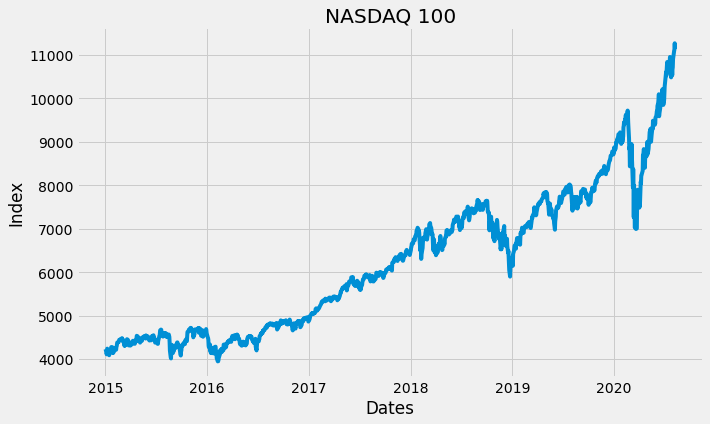

In [4]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Index')
plt.plot(N100_data['NASDAQ 100'])
plt.title('NASDAQ 100')
plt.show()

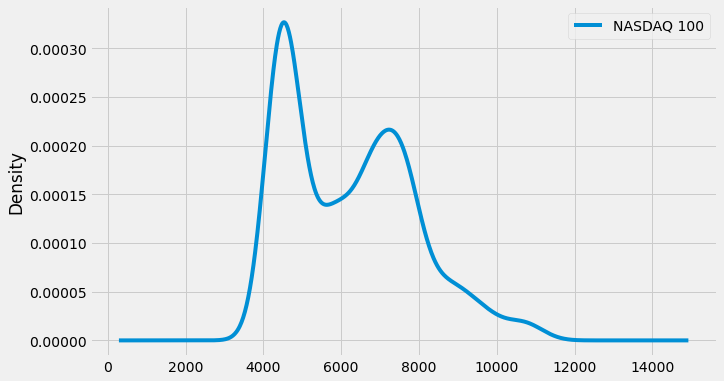

In [5]:
N100_data.plot(kind='kde')

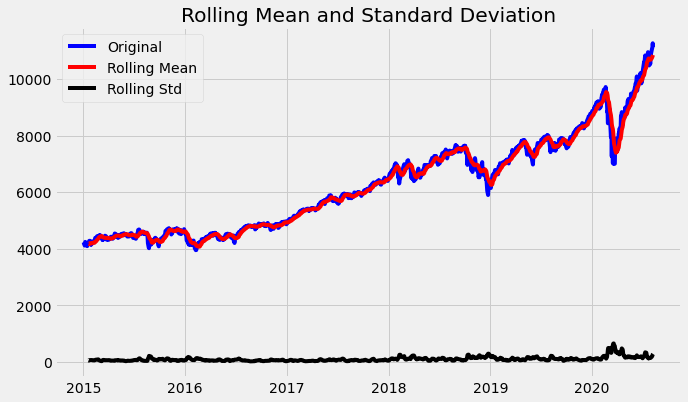

Results of dickey fuller test
Test Statistics                   0.958771
p-value                           0.993811
No. of lags used                  9.000000
Number of observations used    1400.000000
critical value (1%)              -3.435030
critical value (5%)              -2.863607
critical value (10%)             -2.567870
dtype: float64


In [6]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(N100_data)

<Figure size 720x432 with 0 Axes>

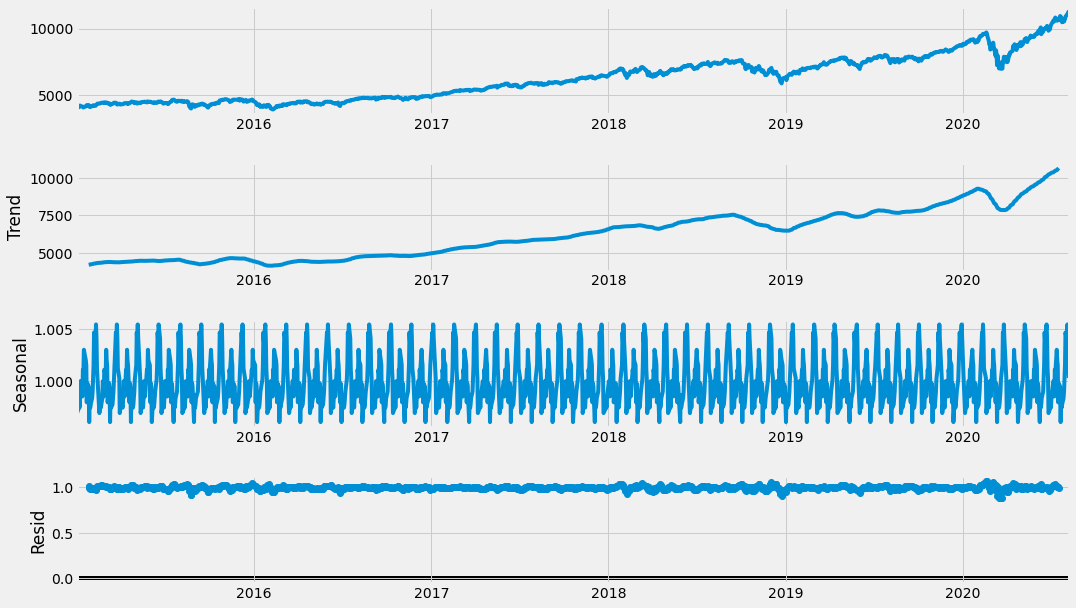

In [7]:
result = seasonal_decompose(N100_data, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


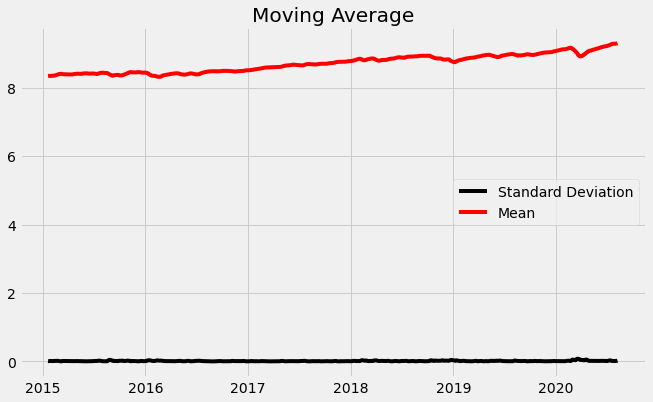

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(N100_data)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

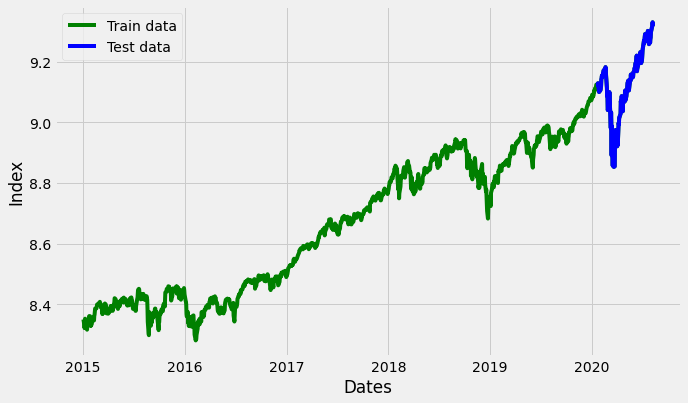

In [9]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Index')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [10]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7867.827, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7866.844, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7866.951, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7865.634, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7865.887, Time=0.44 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.176 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1266
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3935.913
Date:                Sun, 16 Aug 2020   AIC                          -7867.827
Time:                        18:50:33   BIC                          -7857.541
Sample:                             0   HQIC                         -7863.962
                               - 1266                                  

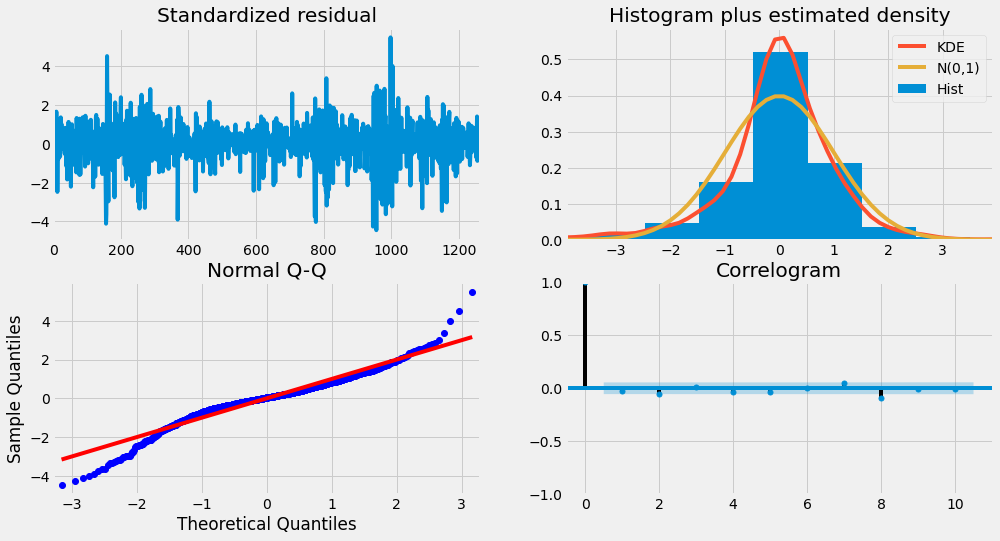

In [11]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [12]:
model = ARIMA(train_data, order=(0, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.NASDAQ 100   No. Observations:                 1265
Model:                 ARIMA(0, 1, 0)   Log Likelihood                3935.913
Method:                           css   S.D. of innovations              0.011
Date:                Sun, 16 Aug 2020   AIC                          -7867.827
Time:                        18:51:38   BIC                          -7857.541
Sample:                             1   HQIC                         -7863.962
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      2.049      0.040    2.71e-05       0.001


/opt/anaconda3/envs/pyadv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/pyadv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


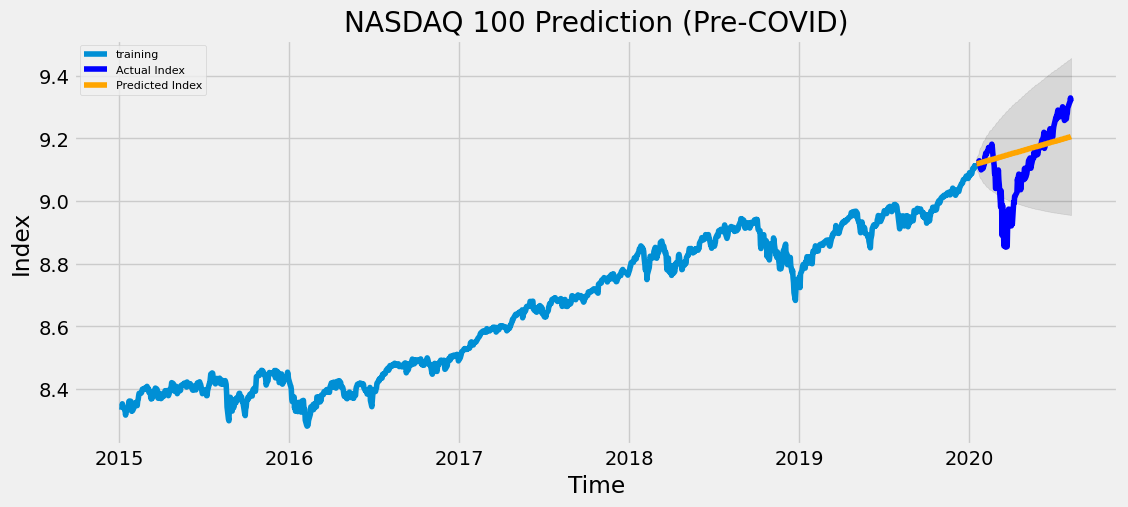

In [13]:
# Forecast
fc, se, conf = fitted.forecast(141, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Index')
plt.plot(fc_series, color = 'orange',label='Predicted Index')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('NASDAQ 100 Prediction (Pre-COVID)')
plt.xlabel('Time')
plt.ylabel('Index')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [14]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
#mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
#print('MAPE: '+str(mape))

MSE: 0.010623813216375148
MAE: 0.07671708245445628
RMSE: 0.10307188373351459


In [15]:
fc_series

Date
2020-01-17    9.119394
2020-01-21    9.120015
2020-01-22    9.120636
2020-01-23    9.121257
2020-01-24    9.121878
                ...   
2020-08-03    9.203843
2020-08-04    9.204464
2020-08-05    9.205085
2020-08-06    9.205706
2020-08-07    9.206327
Length: 141, dtype: float64

In [16]:
forecasted_index = np.exp(fc_series)
forecasted_index

Date
2020-01-17    9130.667933
2020-01-21    9136.339387
2020-01-22    9142.014364
2020-01-23    9147.692865
2020-01-24    9153.374894
                 ...     
2020-08-03    9935.240891
2020-08-04    9941.412100
2020-08-05    9947.587143
2020-08-06    9953.766020
2020-08-07    9959.948736
Length: 141, dtype: float64

In [17]:
forecasted_index.to_csv('N100_forecast_PreCovid.csv', index=True)

In [18]:
N100_data_PosCovid = N100_data.iloc[1305:,]
N100_data_PosCovid

,NASDAQ 100
Date,
2020-03-11,8006.12
2020-03-12,7263.65
2020-03-13,7995.26
2020-03-16,7020.38
2020-03-17,7473.95
...,...
2020-08-03,11055.08
2020-08-04,11096.54
2020-08-05,11125.44


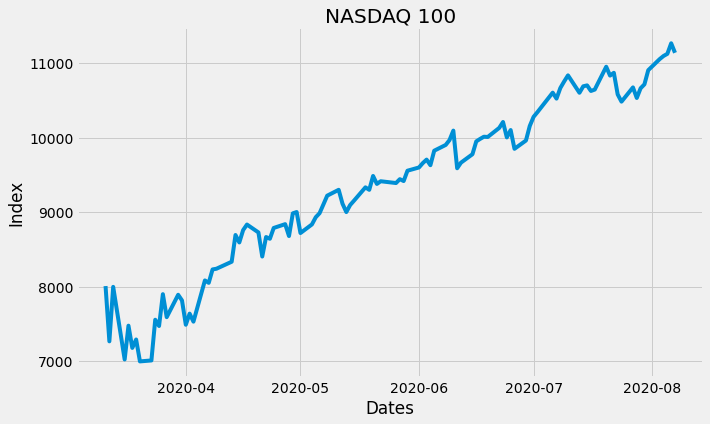

In [19]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Index')
plt.plot(N100_data_PosCovid['NASDAQ 100'])
plt.title('NASDAQ 100')
plt.show()

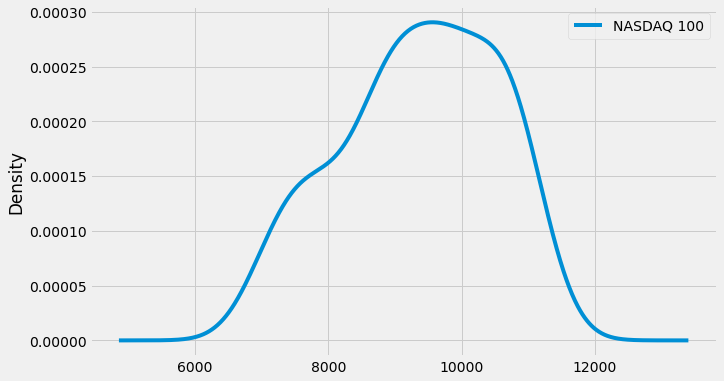

In [20]:
N100_data_PosCovid.plot(kind='kde')

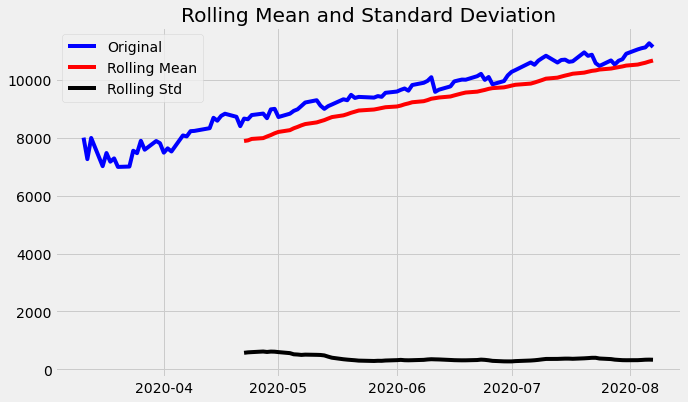

Results of dickey fuller test
Test Statistics                -1.081563
p-value                         0.722368
No. of lags used                6.000000
Number of observations used    98.000000
critical value (1%)            -3.498910
critical value (5%)            -2.891516
critical value (10%)           -2.582760
dtype: float64


In [21]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(N100_data_PosCovid)

<Figure size 720x432 with 0 Axes>

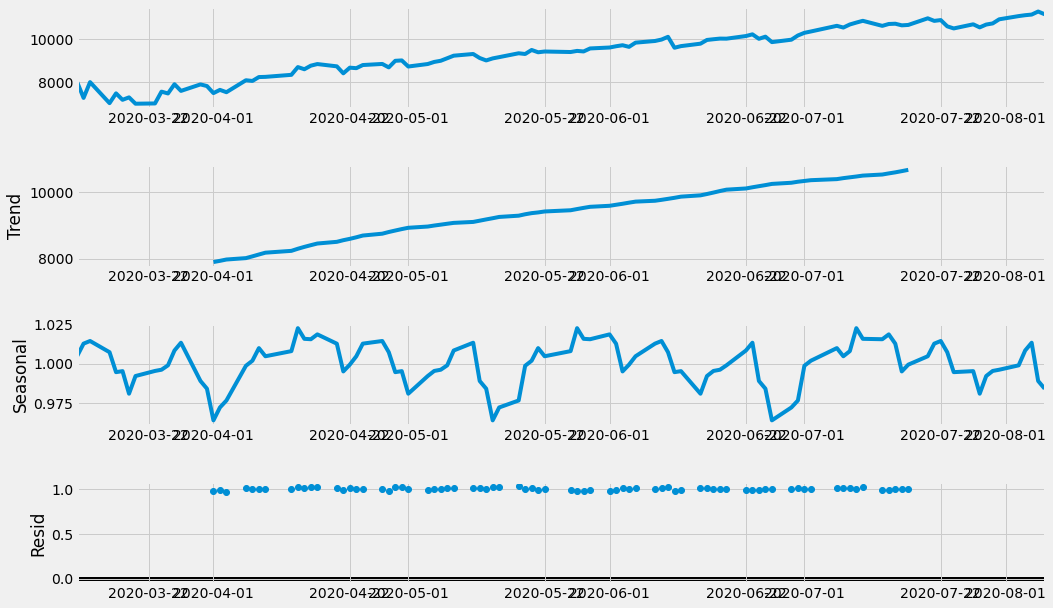

In [22]:
result = seasonal_decompose(N100_data_PosCovid, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


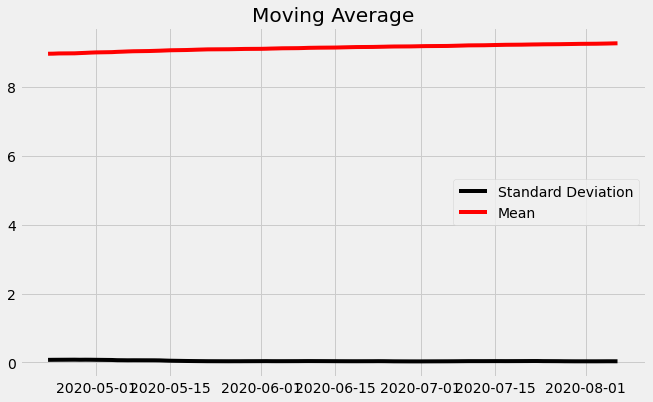

In [23]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(N100_data_PosCovid)
moving_avg = df_log.rolling(30).mean()
std_dev = df_log.rolling(30).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

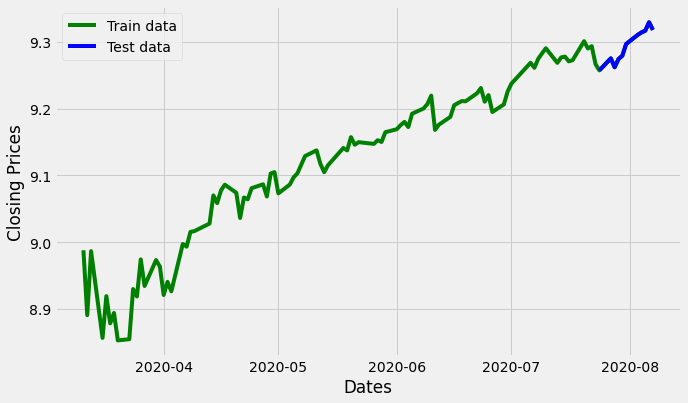

In [24]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [25]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-423.735, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-435.696, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-435.309, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-422.109, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-433.785, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-433.840, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-431.691, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-430.236, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.753 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 220.848
Date:                Sun, 16 Aug 2020   AIC                           -435.696
Time:                        18:53:4

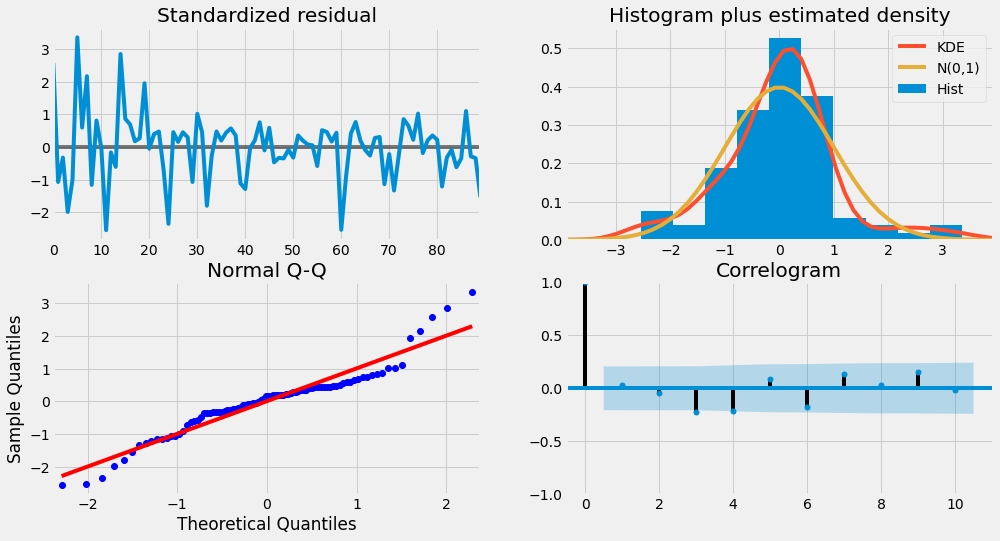

In [26]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [27]:
model = ARIMA(train_data, order=(1, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.NASDAQ 100   No. Observations:                   90
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 220.848
Method:                       css-mle   S.D. of innovations              0.021
Date:                Sun, 16 Aug 2020   AIC                           -435.696
Time:                        18:54:10   BIC                           -428.197
Sample:                             1   HQIC                          -432.672
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0045      0.002      2.842      0.004       0.001       0.008
ar.L1.D.NASDAQ 100    -0.3961      0.102     -3.897      0.000      -0.595      -0.197
                    

/opt/anaconda3/envs/pyadv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/pyadv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


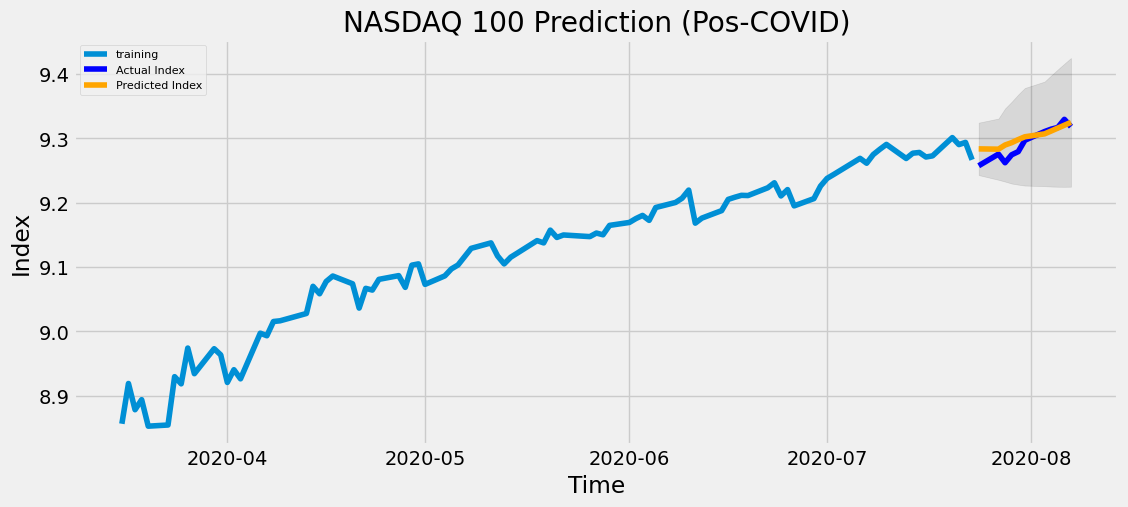

In [28]:
# Forecast
fc, se, conf = fitted.forecast(11, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Index')
plt.plot(fc_series, color = 'orange',label='Predicted Index')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('NASDAQ 100 Prediction (Pos-COVID)')
plt.xlabel('Time')
plt.ylabel('Index')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [29]:
forecasted_index = np.exp(fc_series)
forecasted_index.to_csv('N100_forecast_PosCovid.csv', index=True)